<a href="https://colab.research.google.com/github/vjmiyagi/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/VJMLS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
# Imports
import sys
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Setup DataFrame

In [0]:
%%capture


# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [4]:
# Set display options and sum nums
pd.set_option('display.max_rows', 50)
# Sum null values by column and sort from least to greatest
df.isnull().sum().sort_values()

bathrooms                  0
garden_patio               0
loft                       0
exclusive                  0
terrace                    0
new_construction           0
swimming_pool              0
balcony                    0
high_speed_internet        0
dining_room                0
outdoor_space              0
roof_deck                  0
laundry_in_unit            0
pre-war                    0
fitness_center             0
laundry_in_building        0
no_fee                     0
dishwasher                 0
bedrooms                   0
created                    0
latitude                   0
longitude                  0
wheelchair_access          0
price                      0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
interest_level             0
common_outdoor_space       0
street_address            10
display_address          133
description             1425
dtype: int64

 Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.


In [0]:
y = df['created']>=('2016-06')
x = df['created']<('2016-06')

In [6]:
df[x]

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49346,1.0,1,2016-04-22 15:44:11,24hr Doorman Luxury building in the heart of t...,East 10th Street,40.7296,-73.9869,4500,166 2nd avenue,medium,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df[y].head()


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1.0,1,2016-06-03 03:21:22,Check out this one bedroom apartment in a grea...,W. 173rd Street,40.8448,-73.9396,1675,644 W. 173rd Street,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1.0,1,2016-06-01 03:11:01,Spacious 1-Bedroom to fit King-sized bed comfo...,East 56th St..,40.7584,-73.9648,3050,315 East 56th St..,low,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,2.0,4,2016-06-07 04:39:56,SPRAWLING 2 BEDROOM FOUND! ENJOY THE LUXURY OF...,W 18 St.,40.7391,-73.9936,7400,30 W 18 St.,medium,1,1,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0


 Engineer at least two new features. (See below for explanation & ideas.)


In [8]:
# Ideal bedroom to bathroom ratio is 3:2, mathmatically
# But that  produces NaN values no good...This method better
df['bedbath'] = df['bedrooms'] + (df['bathrooms']*0.1)
df['bedbath'].head()

0    3.15
1    2.10
2    1.10
3    1.10
4    4.10
Name: bedbath, dtype: float64

In [9]:
df.isnull().sum()

bathrooms                  0
bedrooms                   0
created                    0
description             1425
display_address          133
latitude                   0
longitude                  0
price                      0
street_address            10
interest_level             0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
dishwasher                 0
no_fee                     0
laundry_in_building        0
fitness_center             0
pre-war                    0
laundry_in_unit            0
roof_deck                  0
outdoor_space              0
dining_room                0
high_speed_internet        0
balcony                    0
swimming_pool              0
new_construction           0
terrace                    0
exclusive                  0
loft                       0
garden_patio               0
wheelchair_access          0
common_outdoor_space       0
bedbath       

In [10]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath'],
      dtype='object')

In [0]:
df_perks = df[[ 'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space']]

In [12]:
df_perks.head()

,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df_perks['perks'] = 0
df_perks['perks'] = df_perks.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [251]:
df_perks

,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,perks
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
49348,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,9
49349,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
49350,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [14]:
df['perks'] = df_perks['perks']
df['perks'].head()

0    0
1    5
2    3
3    2
4    1
Name: perks, dtype: int64

In [15]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath',
       'perks'],
      dtype='object')

In [16]:
df['zip']=0
df['zip'].head()

0    0
1    0
2    0
3    0
4    0
Name: zip, dtype: int64

In [18]:
df_zip = pd.read_csv('nycaptzippostoffice.csv')
df_zip.head()

,Unnamed: 0,latitude,longitude,zip,po
0,0,40.7145,-73.9425,11211,Brooklyn
1,1,40.7947,-73.9667,10162,New York
2,2,40.7388,-74.0018,10011,New York
3,3,40.7539,-73.9677,10171,New York
4,4,40.8241,-73.9493,10031,New York


In [0]:
df_zip.drop(columns='Unnamed: 0', inplace=True)

In [20]:
df_zip.isna().sum()

latitude     0
longitude    0
zip          0
po           1
dtype: int64

In [21]:
df['zip'] = df_zip['zip']
df['po'] = df_zip['po']
df['zip'].head(), df['po'].head()

(0    11211.0
 1    10162.0
 2    10011.0
 3    10171.0
 4    10031.0
 Name: zip, dtype: float64, 0    Brooklyn
 1    New York
 2    New York
 3    New York
 4    New York
 Name: po, dtype: object)

In [22]:
NY = df['zip'].isna()
df[NY]

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bedbath,perks,zip,po
27800,1.5,2,2016-05-02 03:13:55,[ The Apartment ] - Extra Large Junior 4 locat...,East 63rd Street,40.7633,-73.9628,4300,245 East 63rd Street,low,1,0,1,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.15,7,NaN,NaN
27801,1.0,1,2016-05-03 04:22:27,"This is a fantastic One Bedroom, One bathroom ...",300 East 75th Street,40.7704,-73.9566,3790,300 East 75th Street,low,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,5,NaN,NaN
27802,1.0,0,2016-05-13 04:45:11,WELCOME HOME!<br><br>NOFEE!<br><br>This beauti...,E 67th St,40.7660,-73.9612,2195,229 E 67th St,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.10,0,NaN,NaN
27803,1.0,1,2016-05-07 02:37:58,CooperCooper.com :: Web ID #146598; Access 100...,West 20th Street,40.7456,-74.0053,4150,460 West 20th Street,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,5,NaN,NaN
27804,1.0,2,2016-05-11 04:49:53,Beautiful 3 bedroom in the heart of flatiron H...,E 22 Street,40.7401,-73.9887,4850,12 E 22 Street,low,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.10,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.10,5,NaN,NaN
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1.10,9,NaN,NaN
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,5,NaN,NaN
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.10,5,NaN,NaN


In [0]:
# Found NaN values and looked up using larger database and determined they were
# probably all 10018, NY, NY and for purposes of this assignment that should be
# Just fine.
df[NY]

df['zip'].mask(df['zip'].isna(),10018, inplace=True)

df['po'].mask(df['po'].isna(),'New York', inplace=True)

In [24]:
df['po'].value_counts()

New York               44886
Brooklyn                2542
Astoria                  369
Long Island City         263
Bronx                    160
Forest Hills              98
Sunnyside                 83
Flushing                  80
Rego Park                 72
Elmhurst                  45
Jackson Heights           41
Kew Gardens               33
Woodside                  18
Jamaica                   14
Jersey City               13
Woodhaven                 13
Ridgewood                 13
Corona                    10
Middle Village            10
East Elmhurst              6
Hoboken                    5
Ozone Park                 5
Bayside                    5
Maspeth                    4
Fort Lee                   4
Richmond Hill              3
Glen Oaks                  3
West New York              3
Arverne                    2
Valley Stream              2
Fresh Meadows              1
New Rochelle               1
Saint Albans               1
Oakland Gardens            1
Staten Island 

In [26]:
dfny = pd.read_csv('nyczip.csv')
dfny.head()


,borough,neighbood,zip,Unnamed: 3
0,Bronx,Central Bronx,10453,NaN
1,Bronx,Central Bronx,10457,NaN
2,Bronx,Central Bronx,10460,NaN
3,Bronx,Bronx Park and Fordham,10458,NaN
4,Bronx,Bronx Park and Fordham,10467,NaN


In [0]:
dfny.drop(columns='Unnamed: 3', inplace=True)
dfny.rename(columns={'neighbood':"neighborhood"}, inplace=True)

In [28]:
dfny.head()

,borough,neighborhood,zip
0,Bronx,Central Bronx,10453
1,Bronx,Central Bronx,10457
2,Bronx,Central Bronx,10460
3,Bronx,Bronx Park and Fordham,10458
4,Bronx,Bronx Park and Fordham,10467


In [0]:
df['neighborhood']=""

In [30]:
df.head(10)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bedbath,perks,zip,po,neighborhood
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.15,0,11211.0,Brooklyn,
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.10,5,10162.0,New York,
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,3,10011.0,New York,
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,2,10171.0,New York,
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,1,10031.0,New York,
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.20,0,10011.0,New York,
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.10,3,10025.0,New York,
7,2.0,1,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,40.7427,-73.9957,5645,155 West 21st Street,low,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1.20,8,10011.0,New York,
8,1.0,1,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,40.8234,-73.9457,1725,63 Hamilton Terrace,medium,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,4,10030.0,New York,
9,2.0,4,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,40.7278,-73.9808,5800,522 E 11th,low,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.20,2,10009.0,New York,


In [0]:
df['zip']=df['zip'].astype(int)

In [32]:
df['zip'].head()

0    11211
1    10162
2    10011
3    10171
4    10031
Name: zip, dtype: int64

In [33]:
dfny['zip'].head()

0    10453
1    10457
2    10460
3    10458
4    10467
Name: zip, dtype: int64

In [0]:
df['borough']=""

In [35]:
df.columns


Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath',
       'perks', 'zip', 'po', 'neighborhood', 'borough'],
      dtype='object')

In [36]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath',
       'perks', 'zip', 'po', 'neighborhood', 'borough'],
      dtype='object')

In [49]:
dfny.columns

Index(['borough', 'neighborhood', 'zip'], dtype='object')

In [0]:
df['borough'] = df['zip'].map(dfny.set_index('zip')['borough'])

In [0]:
df['neighborhood'] = df['zip'].map(dfny.set_index('zip')['neighborhood'])

In [52]:
df[['neighborhood','borough']].head()

,neighborhood,borough
0,Greenpoint,Brooklyn
1,NaN,NaN
2,Chelsea and Clinton,Manhattan
3,NaN,NaN
4,Inwood and Washington Heights,Manhattan


In [53]:
df[['neighborhood','borough']].isna().sum()

neighborhood    3692
borough         3692
dtype: int64

In [54]:
df['neighborhood'].value_counts()

Chelsea and Clinton              25412
Upper East Side                   4225
Lower East Side                   2847
Gramercy Park and Murray Hill     2736
Lower Manhattan                   1466
Upper West Side                   1402
Greenwich Village and Soho        1138
Central Harlem                     927
Northwest Brooklyn                 837
Inwood and Washington Heights      813
Northwest Queens                   532
Central Brooklyn                   526
East Harlem                        466
Greenpoint                         404
Bushwick and Williamsburg          295
West Central Queens                193
Flatbush                           185
West Queens                        124
Borough Park                       112
Sunset Park                         69
Bronx Park and Fordham              63
Southern Brooklyn                   55
Southwest Queens                    54
Southwest Brooklyn                  46
Kingsbridge and Riverdale           43
North Queens             

In [55]:
df['borough'].value_counts()

Manhattan        41432
Brooklyn          2542
Queens             990
Bronx              160
Staten Island        1
Name: borough, dtype: int64

In [0]:
z = df['zip'] < 10000

In [57]:
df[z]

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bedbath,perks,zip,po,neighborhood,borough
253,2.0,3,2016-04-21 02:44:36,Unbeatable location in this Murray Hill Flex 3...,Lexington Ave.,40.7449,-73.9812,6150,184 Lexington Ave.,low,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,3.2,6,7310,Jersey City,NaN,NaN
376,1.0,2,2016-04-12 02:48:43,Ridiculously LARGE & BRIGHT already Flexed QUE...,Bleecker Street,40.7284,-73.9992,3500,147 Bleecker Street,high,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.1,5,7093,West New York,NaN,NaN
871,2.0,2,2016-04-03 02:11:48,This stunning apartment features a newly renov...,Columbus Avenue,40.7926,-73.9680,5775,730 Columbus Avenue,low,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.2,4,7310,Jersey City,NaN,NaN
2993,2.0,3,2016-04-06 03:12:29,A stunning mix of historic and modern finishes...,Front St.,40.7074,-74.0021,8250,225 Front St.,low,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.2,8,7030,Hoboken,NaN,NaN
3879,0.0,1,2016-06-12 13:41:43,,West 77 St,40.7835,-73.9837,2525,338 West 77 St,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,7310,Jersey City,NaN,NaN
4895,1.0,1,2016-04-30 03:48:43,Newly Constructed luxury building in Lincoln C...,W 67 St.,40.7756,-73.9846,2995,200 W 67 St.,medium,1,0,1,0,1,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1.1,9,7093,West New York,NaN,NaN
5090,1.0,1,2016-04-26 04:58:50,**UNBELIEVABLE LOCATION-STEPS TO 30th AVE****G...,31st Avenue,40.7656,-73.9256,1950,25-21 31st Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.1,0,7093,West New York,NaN,NaN
5123,2.0,2,2016-04-22 02:30:11,CooperCooper.com :: Web ID #178304; Access 100...,West 26th Street,40.7448,-73.9909,6561,55 West 26th Street,low,1,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.2,6,7024,Fort Lee,NaN,NaN
6371,2.0,3,2016-04-22 03:54:39,NO BROKER FEE! 1 MONTH FREE RENT!<br /><br />...,W 31 Street,40.7486,-73.9903,8795,125 W 31 Street,low,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.2,8,7086,Weehawken,NaN,NaN
6711,1.0,1,2016-04-12 04:11:37,"Fabulous one bedroom located in a beautiful, t...",W 22 St.,40.7447,-73.9997,2850,308 W 22 St.,medium,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.1,5,7310,Jersey City,NaN,NaN


In [58]:
df[z].shape

(28, 40)

In [0]:
df.loc[df['zip']<=10000, 'borough'] = 'NJ'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# New Section

 Fit a linear regression model with at least two features.


In [61]:
df['borough'].value_counts()

Manhattan        41432
Brooklyn          2542
Queens             990
Bronx              160
NJ                  28
Staten Island        1
Name: borough, dtype: int64

In [0]:
hot = pd.get_dummies(df.borough)

In [118]:
hot.shape

(48817, 6)

In [119]:
hot.head()

,Bronx,Brooklyn,Manhattan,NJ,Queens,Staten Island
0,0,1,0,0,0,0
1,0,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,0
4,0,0,1,0,0,0


In [0]:
df = pd.concat([df,hot], axis=1).copy()

In [0]:
hot = pd.get_dummies(df.interest_level)

In [183]:
hot

,high,low,medium
0,0,0,1
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0
...,...,...,...
49347,0,0,1
49348,0,1,0
49349,0,1,0
49350,0,1,0


In [0]:
df = pd.concat([df,hot], axis=1).copy()

In [185]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bedbath,perks,zip,po,neighborhood,borough,train,test,Bronx,Brooklyn,Manhattan,NJ,Queens,Staten Island,high,low,medium
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.15,0,11211,Brooklyn,Greenpoint,Brooklyn,0,1,0,1,0,0,0,0,0,0,1
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.10,5,10162,New York,NaN,NaN,0,1,0,0,0,0,0,0,0,1,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,3,10011,New York,Chelsea and Clinton,Manhattan,1,0,0,0,1,0,0,0,1,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,2,10171,New York,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,1,10031,New York,Inwood and Washington Heights,Manhattan,1,0,0,0,1,0,0,0,0,1,0


In [128]:
df.shape

(48817, 48)

In [129]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,bedbath,perks,zip,po,neighborhood,borough,train,test,Bronx,Brooklyn,Manhattan,NJ,Queens,Staten Island
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.15,0,11211,Brooklyn,Greenpoint,Brooklyn,0,1,0,1,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.10,5,10162,New York,NaN,NaN,0,1,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,3,10011,New York,Chelsea and Clinton,Manhattan,1,0,0,0,1,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,2,10171,New York,NaN,NaN,1,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,1,10031,New York,Inwood and Washington Heights,Manhattan,1,0,0,0,1,0,0,0


In [100]:
type(df['created'])


pandas.core.series.Series

In [0]:
df['train'] = ''

In [0]:
df['test'] = ''

# y = df['created']>=('2016-06')
# x = df['created']<('2016-06')

In [0]:
df.loc[(df.created < ('2016-06'),'train')]=1

In [0]:
df.loc[(df.created < ('2016-06'),'test')]=0

In [109]:
df['train'].head()

0     
1     
2    1
3    1
4    1
Name: train, dtype: object

In [0]:
df.loc[(df.created >= ('2016-06'), 'train')]=0

In [0]:
df.loc[(df.created >= ('2016-06'), 'test')]=1

In [113]:
df[['train','test']].head()

,train,test
0,0,1
1,0,1
2,1,0
3,1,0
4,1,0


In [130]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath',
       'perks', 'zip', 'po', 'neighborhood', 'borough', 'train', 'test',
       'Bronx', 'Brooklyn', 'Manhattan', 'NJ', 'Queens', 'Staten Island'],
      dtype='object')

In [250]:
#@title Default title text { run: "auto" }
locat = "Manhattan" #@param ["Manhattan", "Brooklyn", "Bronx", "Queens", "New Jersey"]

# set up train and test df for filter by location

# y = ('2016-06')
# x < ('2016-06')

if locat == 'Manhattan':
    train = df.loc[((df['train']==1) & (df['Manhattan']==1))]
    test = df.loc[((df['test']==1) & (df['Manhattan']==1))]
if locat == "Brooklyn":
    train = df.loc[((df['train']==1) & (df['Brooklyn']==1))]
    test = df.loc[((df['test']==1) & (df['Brooklyn']==1))]
if locat =='Bronx':
    train = df.loc[((df['train']==1) & (df['Bronx']==1))]
    test = df.loc[((df['test']==1) & (df['Bronx']==1))]
if locat =="Queens":
    train = df.loc[((df['train']==1) & (df['Queens']==1))]
    test = df.loc[((df['test']==1) & (df['Queens']==1))]
if locat == "New Jersey":
    train = df.loc[((df['train']==1) & (df['NJ']==1))]
    test = df.loc[((df['test']==1) & (df['NJ']==1))]

print(train.shape)
print(test.shape)


# Scatterplot of relationship between bedroom to bathroom ratio, perks and price
import plotly.express as px

px.scatter_3d(
    train,
    x='price',
    y='bedbath',
    z='perks',
    title = 'NYC Apartment Prices'
)


(28532, 51)
(12900, 51)


In [251]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath',
       'perks', 'zip', 'po', 'neighborhood', 'borough', 'train', 'test',
       'Bronx', 'Brooklyn', 'Manhattan', 'NJ', 'Queens', 'Staten Island',
       'high', 'low', 'medium'],
      dtype='object')

In [252]:
target = 'price'
high_cardinality = ['display_address', 'created', 'street_address', 'description', 'po','zip','borough','neighborhood','train','test', 'interest_level']
features = train.columns.drop(high_cardinality + [target]).to_list()
features

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'elevator',
 'cats_allowed',
 'hardwood_floors',
 'dogs_allowed',
 'doorman',
 'dishwasher',
 'no_fee',
 'laundry_in_building',
 'fitness_center',
 'pre-war',
 'laundry_in_unit',
 'roof_deck',
 'outdoor_space',
 'dining_room',
 'high_speed_internet',
 'balcony',
 'swimming_pool',
 'new_construction',
 'terrace',
 'exclusive',
 'loft',
 'garden_patio',
 'wheelchair_access',
 'common_outdoor_space',
 'bedbath',
 'perks',
 'Bronx',
 'Brooklyn',
 'Manhattan',
 'NJ',
 'Queens',
 'Staten Island',
 'high',
 'low',
 'medium']

In [263]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath',
       'perks', 'zip', 'po', 'neighborhood', 'borough', 'train', 'test',
       'Bronx', 'Brooklyn', 'Manhattan', 'NJ', 'Queens', 'Staten Island',
       'high', 'low', 'medium'],
      dtype='object')

In [0]:
target = 'price'
y_train = train[target]
y_test = test[target]

features = ['bedbath', 'Manhattan','perks']

X_train = train[features].copy()
X_test = test[features].copy()

In [265]:
train[features]

,bedbath,Manhattan,perks
2,1.1,1,3
4,4.1,1,1
5,4.2,1,0
6,2.1,1,3
7,1.2,1,8
...,...,...,...
49346,1.1,1,5
49348,1.1,1,9
49349,1.1,1,5
49350,0.1,1,5


In [255]:
y_train

2        2850
4        3350
5        7995
6        3600
7        5645
         ... 
49346    4500
49348    3950
49349    2595
49350    3350
49351    2200
Name: price, Length: 28532, dtype: int64

In [256]:
y_test

11       1675
14       3050
24       7400
34       2300
39       2396
         ... 
49305    2295
49310    3995
49320    2727
49332    4850
49347    3200
Name: price, Length: 12900, dtype: int64

In [266]:
X_train

,bedbath,Manhattan,perks
2,1.1,1,3
4,4.1,1,1
5,4.2,1,0
6,2.1,1,3
7,1.2,1,8
...,...,...,...
49346,1.1,1,5
49348,1.1,1,9
49349,1.1,1,5
49350,0.1,1,5


In [267]:
X_test

,bedbath,Manhattan,perks
11,1.1,1,0
14,1.1,1,3
24,4.2,1,11
34,2.1,1,4
39,0.1,1,13
...,...,...,...
49305,2.1,1,2
49310,3.1,1,8
49320,1.1,1,2
49332,2.1,1,4


In [268]:
model = LinearRegression()
model.fit(X_train, y_train )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [270]:
guess = y_train.mean()

y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Test error: {mae:.2f} percentage points')

Test error: 1201.80 percentage points


In [271]:
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} percentage points')

Test Error: 1197.36 percentage points


 Get the model's coefficients and intercept.


In [272]:
model.intercept_, model.coef_

(1644.8344211672102, array([818.42562449,   0.        , 123.10742971]))

In [273]:
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 1644.8344211672102
bedbath      818.425624
Manhattan      0.000000
perks        123.107430


In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m,b):
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature,target, ax = ax)

    #Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x+b

    # Plot predictions
    ax.plot(x,y_pred)

    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1,y2))
        height = abs(y1-y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    print("Mean Squared Error:", mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2', r2)




In [309]:
y_train.mean()

3578.5043459974763

In [311]:
train.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space', 'bedbath',
       'perks', 'zip', 'po', 'neighborhood', 'borough', 'train', 'test',
       'Bronx', 'Brooklyn', 'Manhattan', 'NJ', 'Queens', 'Staten Island',
       'high', 'low', 'medium'],
      dtype='object')

Mean Squared Error: 3110665.8433499616
Root Mean Squared Error: 1763.7079813137893
Mean Absolute Error: 1201.8035982000597
R^2 0.0


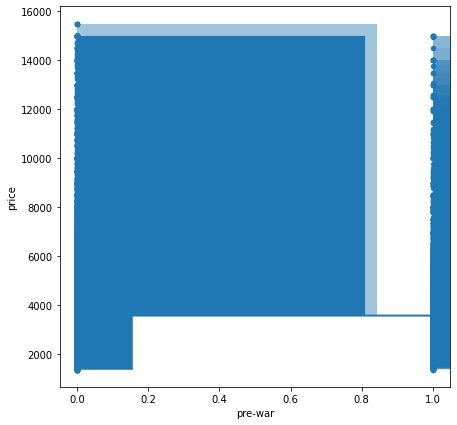

In [315]:
#@title TRAIN { run: "auto" }
feature = "pre-war" #@param ["bathrooms", "bedrooms", "latitude", "longitude", "elevator", "cats_allowed", "hardwood_floors", "dogs_allowed", "doorman", "dishwasher", "no_fee", "laundry_in_building", "fitness_center", "pre-war", "laundry_in_unit", "roof_deck", "outdoor_space", "dining_room", "high_speed_internet", "balcony", "swimming_pool", "new_construction", "terrace", "exclusive", "loft", "garden_patio", "wheelchair_access", "common_outdoor_space", "bedbath", "perks", "Bronx", "Brooklyn", "Manhattan", "NJ", "Queens", "high", "low", "medium"]

squared_errors(train, feature, target,m=0, b=y_train.mean())

 Get regression metrics RMSE, MAE, and  R2 , for both the train and test data.


Mean Squared Error: 3120611.243523412
Root Mean Squared Error: 1766.5251890430013
Mean Absolute Error: 1199.3355303287065
R^2 0.0


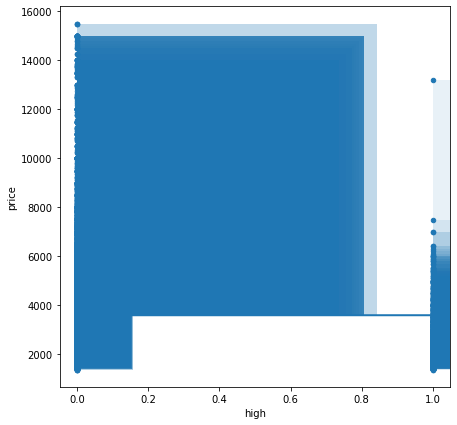

In [317]:
#@title TEST { run: "auto" }
feature = "high" #@param ["bathrooms", "bedrooms", "latitude", "longitude", "elevator", "cats_allowed", "hardwood_floors", "dogs_allowed", "doorman", "dishwasher", "no_fee", "laundry_in_building", "fitness_center", "pre-war", "laundry_in_unit", "roof_deck", "outdoor_space", "dining_room", "high_speed_internet", "balcony", "swimming_pool", "new_construction", "terrace", "exclusive", "loft", "garden_patio", "wheelchair_access", "common_outdoor_space", "bedbath", "perks", "Bronx", "Brooklyn", "Manhattan", "NJ", "Queens", "high", "low", "medium"]

squared_errors(test, feature, target,m=0, b=y_test.mean())

 What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
